<a href="https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/explainable_deep_learning/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05
### Eleanor Jiang


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meovvmiao/aipi-590-xai/blob/dev/hw4/aipi590_hw5.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI" # Change to your repo name
git_path = 'https://github.com/meovvmiao/AIPI-590-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'explainable_deep_learning'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'AIPI-590-XAI'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 80 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 3.04 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/AIPI-590-XAI/explainable_deep_learning
images/


In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 7.0 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=2589d981ee35aecc3b1fb6e1e904b7ca07c30a269c61b39c0e50f402257744f8
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [11]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

In this assignment, I'd like to choose wildlife conservation as my topic.

In [56]:
# Define the directory containing the images
image_directory = '/content/AIPI-590-XAI/explainable_deep_learning/images'

# Define preprocessing transformations for ResNet-50
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess images from the local directory
preprocessed_images = []
original_images = []
selected_labels = [] # Placeholder for labels as we don't have them for these images

# List all files in the directory and filter for image files
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Select at least 5 image files, or all if less than 5 exist
num_images_to_select = min(5, len(image_files))
selected_image_files = np.random.choice(image_files, num_images_to_select, replace=False).tolist()

for image_file in selected_image_files:
    img_path = os.path.join(image_directory, image_file)
    try:
        img = Image.open(img_path).convert('RGB')
        original_images.append(np.array(img))
        img_tensor = preprocess(img)
        preprocessed_images.append(img_tensor)
        selected_labels.append("animal") # Placeholder label
    except FileNotFoundError:
        print(f"Warning: Image file not found at {img_path}. Skipping.")
    except Exception as e:
        print(f"Warning: Could not open or process image file at {img_path}. Skipping. Error: {e}")

# Stack preprocessed images into a batch tensor if the list is not empty
if preprocessed_images:
    input_tensor = torch.stack(preprocessed_images)
    print(f"Shape of input tensor: {input_tensor.shape}")
else:
    print("No images were successfully loaded and preprocessed from the local directory.")
    input_tensor = None # Or handle this case as appropriate

# Print the placeholder labels for the selected images
print(f"Labels for selected images (placeholders): {selected_labels}")

Shape of input tensor: torch.Size([5, 3, 224, 224])
Labels for selected images (placeholders): ['animal', 'animal', 'animal', 'animal', 'animal']


In [57]:
# Load a pretrained ResNet-50 model
model = resnet50(pretrained=True)
model.eval() # Set the model to evaluation mode

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
# Define the target layer for GradCAM
target_layer = model.layer4[-1]

# Since we are just visualizing, we can use a dummy target or the predicted class index.
# Here we assume a classification task and use the predicted class index.
targets = [ClassifierOutputTarget(category) for category in torch.argmax(model(input_tensor), axis=1)]

# Initialize GradCAM, GradCAM++, and HiResCAM
gradcam = GradCAM(model=model, target_layers=[target_layer])
gradcam_plus_plus = GradCAMPlusPlus(model=model, target_layers=[target_layer])
hirescam = HiResCAM(model=model, target_layers=[target_layer])

# Generate heatmaps
gradcam_heatmap = gradcam(input_tensor=input_tensor, targets=targets)
gradcam_plus_plus_heatmap = gradcam_plus_plus(input_tensor=input_tensor, targets=targets)
hirescam_heatmap = hirescam(input_tensor=input_tensor, targets=targets)

print("GradCAM heatmap shape:", gradcam_heatmap.shape)
print("GradCAM++ heatmap shape:", gradcam_plus_plus_heatmap.shape)
print("HiResCAM heatmap shape:", hirescam_heatmap.shape)

# The above code is a reference to github page and collaborate with Gemini

GradCAM heatmap shape: (5, 224, 224)
GradCAM++ heatmap shape: (5, 224, 224)
HiResCAM heatmap shape: (5, 224, 224)


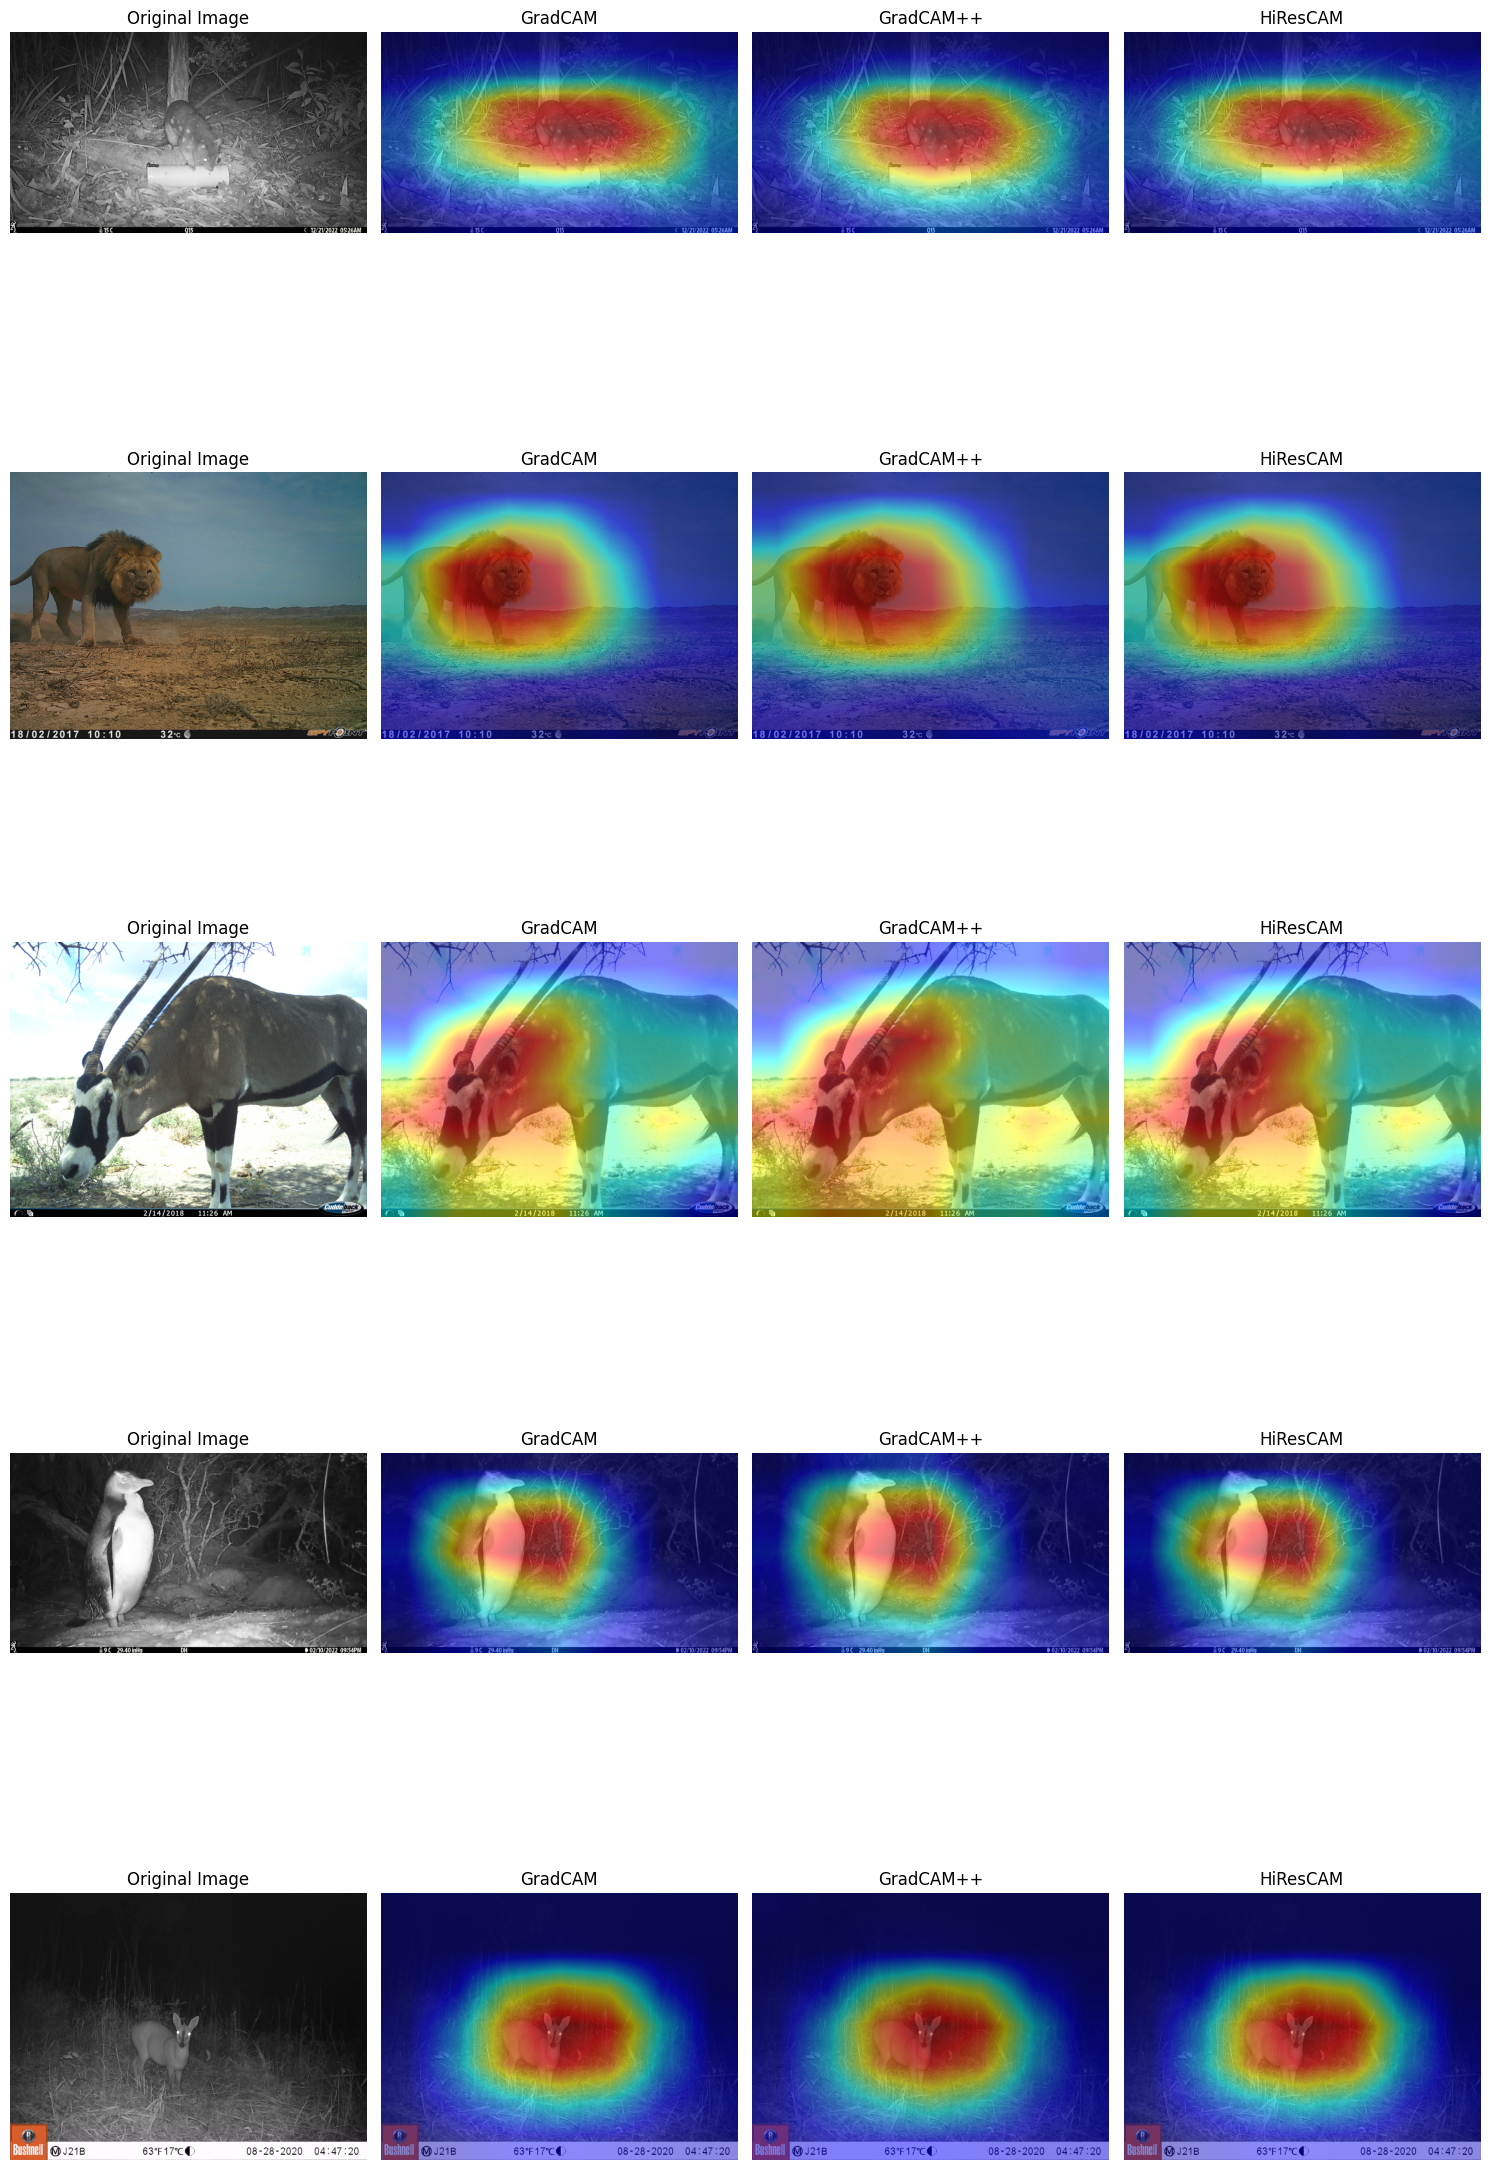

In [60]:
# Visualize the heatmaps
fig, axes = plt.subplots(len(original_images), 4, figsize=(15, 5 * len(original_images)))

# If there's only one image, axes will not be a 2D array, so adjust indexing
if len(original_images) == 1:
    axes = axes.reshape(1, -1)

for i in range(len(original_images)):
    # Original image
    axes[i, 0].imshow(original_images[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Resize heatmaps to the size of the original image
    original_height, original_width, _ = original_images[i].shape
    gradcam_heatmap_resized = np.array(Image.fromarray(gradcam_heatmap[i, :]).resize((original_width, original_height), Image.BICUBIC))
    gradcam_plus_plus_heatmap_resized = np.array(Image.fromarray(gradcam_plus_plus_heatmap[i, :]).resize((original_width, original_height), Image.BICUBIC))
    hirescam_heatmap_resized = np.array(Image.fromarray(hirescam_heatmap[i, :]).resize((original_width, original_height), Image.BICUBIC))


    # GradCAM
    gradcam_viz = show_cam_on_image(original_images[i].astype(np.float32) / 255., gradcam_heatmap_resized, use_rgb=True)
    axes[i, 1].imshow(gradcam_viz)
    axes[i, 1].set_title("GradCAM")
    axes[i, 1].axis('off')

    # GradCAM++
    gradcam_plus_plus_viz = show_cam_on_image(original_images[i].astype(np.float32) / 255., gradcam_plus_plus_heatmap_resized, use_rgb=True)
    axes[i, 2].imshow(gradcam_plus_plus_viz)
    axes[i, 2].set_title("GradCAM++")
    axes[i, 2].axis('off')

    # HiResCAM
    hirescam_viz = show_cam_on_image(original_images[i].astype(np.float32) / 255., hirescam_heatmap_resized, use_rgb=True)
    axes[i, 3].imshow(hirescam_viz)
    axes[i, 3].set_title("HiResCAM")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# The visualization part is generated by Gemini on Oct 5th.

- **Method Differences?** From the above images, we could observe some of the differences. In the first image, for example, we could clear see that the GradCAM++ has the smallest highlight area because it uses a weighted combination of postitive gradients to improve the localization of objects and produce sharper heatmaps. Therefore, we could see that the heatmap of GradCAM++ largely focuses on the main object. In other words, it is better in localiation than other two methods.

- **Any surprising examples?** The above examples show that the model tends to rely on the head of the animals in prediction. In the 4th image, however, we could clearly see that the model's attention is wrong with a focus on penguin's belly instead of head, which could result in wrong recognition.

- **Explainablity is important in wildlife recognition**. In the above examples we reveal the inproficiency in our current model. The model tends to focus on the head of the animals but frequently missed and instead focuses on spurious correlations (backgrond scenery as in the 4th image). To reserve the explainability can help scientists build trust, improve models and address failure cases. If we could have models that clearly highlight facial characteristics of animals, we may have provide better study materials to boilogical understanding and wildlife conservation.

In general,

- **GradCAM** uses the gradients of the target class score with respect to the feature maps of the last convolutional layer to weigh the spatial importance of each feature map. The resulting heatmap highlights regions in the image that were important for the model's prediction. Therefore, GradCAM tends to produce coarser heatmaps.

- **GradCAM++** uses a weighted combination of positive gradients to improve the localization of objects and produce sharper heatmaps, especially for images with multiple instances of an object or for more complex scenes. It aims to address some of the limitations of GradCAM, particularly in accurately localizing objects.

- **HiResCAM** focuses on producing higher-resolution heatmaps. It does this by using a different approach to calculate the importance of each pixel in the feature maps, often involving element-wise multiplication of gradients and feature maps. HiResCAM can provide more detailed insights into which specific pixels contribute to the model's decision.

While GradCAM is the simplest to implement, HiResCAM generally provides the highest resolution and most detailed heatmaps followed by GradCAM++, and then GradCAM; GradCAM++ often improves localization compared to the original GradCAM.